In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipyevents import Event
from ipywidgets import Label
import pickle
import numpy as np
import extinction as ext
import seaborn as sns
from scipy.interpolate import interp1d
import math
from scipy.optimize import curve_fit
from scipy.optimize import leastsq


with open('meta.pickle','rb') as handle:
    meta = pickle.load(handle)

In [238]:
def semilog10x(x,a,b):
    x = np.array(x)
    return a * np.log10(x + 1.) + b

def scale(x,scale):
    x = np.array(x)
    return scale * x

def mag2flux(mag,wave):
    import numpy as np
    mag = np.array(mag)
    wave = np.array(wave)
    return 10**(-0.4*(mag + 2.406 + 5*np.log10(wave)))

def mag2eflux(f,dm):
    import numpy as np
    f = np.array(f)
    dm = np.array(dm)
    return f * np.log(10.) * 0.4 * dm

def linear(x,m,c):
    import numpy as np
    x = np.array(x)
    return m*x + c

def quad(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a*(x-b)**2 + c

def invquad(x,a,b,c):
    return 1./quad(x,a,b,c)

def power(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a*(x/b)**c

def expo(x,a,b):
    import numpy as np
    x = np.array(x)
    return a * np.exp(b * x)

def expo2(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a * np.exp(b*x**2 + c*x)

def planck(wave,temp,scale=1.):
    import numpy as np
    w = np.array(wave) / 1e8 # A to cm
    c1 = 3.7417749e-5 # 2 pi h c c
    c2 = 1.4387687 # h c / k
    val = c2/w/temp
    bbflux = c1 / (w**5 * np.expm1(val))
    return 1e-8 * scale * bbflux # erg/s/cm**2/A

def planckWithBlanket(wave,temp,scale=1.,pow=1.):
    import numpy as np
    wave = np.array(wave)
    trans = wave/4000.
    trans[trans>1.] = 1.
    return planck(wave,temp,scale) * trans**pow

def twoplanck(wave,temp,scale,temp2,scale2):
    return planck(wave,temp,scale) + planck(wave,temp2,scale2)

def temperature2fluxratio(temp,w1,w2):
    return planck(w1,temp)/planck(w2,temp)

def timescalefactor(x,shift,scale):
    # list of x = [stdx,stdy,estdy,mstdy,tarx,tary,etary,shifttary,kind]
    import numpy as np
    stdx,stdy,estdy,mstdy,tarx,tary,etary,shifttary,kind = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8]
    stdx,stdy,estdy = np.array(stdx),np.array(stdy),np.array(estdy)
    tarx,tary,etary = np.array(tarx),np.array(tary),np.array(etary)
    targx = (tarx+shift)*scale
    tary = tary+shifttary
    tgrid = tarx
    mod = interp1d(stdx,stdy/mstdy,kind)
    emod = interp1d(stdx,estdy,kind='nearest')
    try:
        prey = mod(tgrid)
        eprey = emod(tgrid)
        chisq = (prey - tary)**2 / (estdy**2 + etary**2)
    except:
        print('Exception, cannot interpolate p=[{0:.2E} {1:.2E} {2:.2E}]'.format(shift,scale,shifttary))
        chisq = None

    return chisq

In [3]:
wavelength = {'UVW2': 1928.,
            'UVM2': 2246.,
            'UVW1': 2600.,
            'U': 3571., 'u': 3543.,
            'B': 4344., "B'": 4344.,
            'g': 4770.,
            'V': 5456.,
            'R': 6442., 'r': 6231.,
            'I': 7994., 'i': 7625.,
            'J': 12355.,
            'H': 16458.,
            'KS': 21603., "K'": 21603.,
            'I1': 35500.,
            'I2': 44930.,
            'I3': 57310.,
            'I4': 78720.}

# values = mAB - mVega
# Swift calibration (UVW2--V): https://swift.gsfc.nasa.gov/analysis/uvot_digest/zeropts.html
# RI calibration: http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
vega2AB = {'UVW2': 1.73,
          'UVM2': 1.69,
          'UVW1': 1.51,
          'U': 1.02,
          'B': -0.13, "B'": -0.13,
          'V': -0.01,
          'R': 0.21,
          'I': 0.45,
          'H': 1.39,
          'J': 0.91,
          'KS': 1.85, "K'": 1.85}

In [4]:
# load data
s1 = 'https://api.sne.space/'
s2 = list(meta.keys())
s3 = '/photometry/time+instrument+telescope+model+realization+magnitude+e_magnitude+zeropoint+band+bandset+system+upperlimit?format=csv'
sn = pd.DataFrame()
for i in s2:
    if meta[i]['quality']==99:
        continue
    x = pd.read_csv(s1+i+s3)
    sn = sn.append(x)

sn['event'].unique()

array(['SN2009ip', 'SN2013fs', 'SN1998S', 'PTF11iqb', 'SN2007pk',
       'SN2011ht', 'SN1994Y', 'SN2015bh', 'SN2008ip', 'SN2009kr',
       'SN2006aa', 'SN2010jl', 'SN2006jd', 'SN2005kj', 'SN2005ip',
       'SN2006qq'], dtype=object)

In [24]:
dat = sn.copy()

x = dat.copy()

# exclude IR bands
band = ['J','H','KS','I1','I2','K','z','y','C','Y','Ks',"g'",'g']
x = x[~x['band'].isin(band)]
x = x[x['band'].notnull()]
x = x[x['upperlimit']!='T']

# exclude bands
key = {'SN2013fs': ['r','i','g']
      ,'PTF11iqb': ['r']
      ,'SN2007pk': ["i'",'R']
      ,'SN2006aa': ["V'","B'","g'"]
      ,'SN2010jl': ['I','U','R']
      ,'SN2006jd': ['U']
      ,'SN2005kj': ["B'","V'"]
      ,'SN2006qq': ["B'","V'"]}
for i in key.keys():
    a = x[x['event']==i]
    b = x[x['event']!=i]
    for j in key[i]:
        a = a[a['band']!=j]
    x = a.append(b)
    
# phase
b = None
for i in x['event'].unique():
    a = x[x['event']==i]
    a['phase'] = (a['time'] - meta[i]['maxOptical'])/(1. + meta[i]['redshift'])
    try:
        b = b.append(a)
    except:
        b = a.copy()
x = b.copy()

# vega2AB
b = None
for i in x['band'].unique():
    a = x[x['band']==i]
    if not i in {"r'","i'","u'",'u','r','i'}:
        a['magAB'] = a['magnitude'] + vega2AB[i]
    else:
        a['magAB'] = a['magnitude']
    try:
        b = b.append(a)
    except:
        b = a
x = b.copy()

# change
key = {'SN2013fs': [("r'",'R')]
      ,'SN2008ip': [("r'",'R'),("i'",'I')]
      ,'SN2007pk': [("r'",'R')]
      ,'SN2006aa': [("u'",'U'),("r'",'R'),("i'",'I')]
      ,'SN2010jl': [("i'",'I'),("u'",'U'),("r'",'R')]
      ,'SN2006jd': [('u','U')]
      ,'SN2005kj': [("r'",'R'),("i'",'I'),("u'",'U')]
      ,'SN2005ip': [('r','R'),('i','I'),('u','U')]
      ,'SN2006qq': [("i'",'I'),("r'",'R'),("u'",'U')]}
for i in key.keys():
    a = x[x['event']==i]
    b = x[x['event']!=i]
    for j in key[i]:
        aa = a[a['band']==j[0]]
        aaa = a[a['band']!=j[0]]
        aa['band'] = j[1]
        a = aa.append(aaa)
    x = a.append(b)

# de-reddenning
c = None
for i in x['event'].unique():
    a = x[x['event']==i]
    for j in a['band'].unique():
        b = a[a['band']==j]
        b['magAB'] = b['magAB'] - ext.fm07(np.array([wavelength[j]]), 3.1*meta[i]['ebvGal'])[0]
        try:
            c = c.append(b)
        except:
            c = b.copy()
x = c.copy()  

# choose columns
key = ['event','phase','band','magAB','e_magnitude']   
x = x[key].copy()

# filter phase
key = {'SN2009ip': (-12,100)
      ,'SN2011ht': (-50,100)
      ,'SN2007pk': (-50,100)
      ,'PTF11iqb': (-50,100)
      ,'SN2013fs': (-50,100)
      ,'SN2006aa': (-30,30)
      ,'SN2008ip': (-50,100)
      ,'SN1998S': (-50,100)
      ,'SN1994Y': (-50,100)
      ,'SN2015bh': (-50,100)
      ,'SN2009kr': (-50,100)}
b = None
for i in key.keys():
    a = x[x['event']==i]
    a = a[a['phase']>=key[i][0]]
    a = a[a['phase']<=key[i][1]]
    try:
        b = b.append(a)
    except:
        b = a.copy()
x = b.copy()

dat = x.copy()

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

# Interpolate

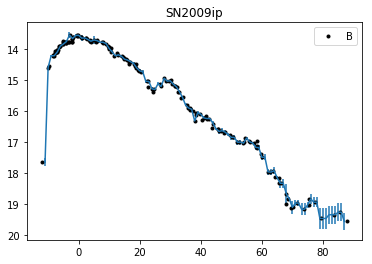

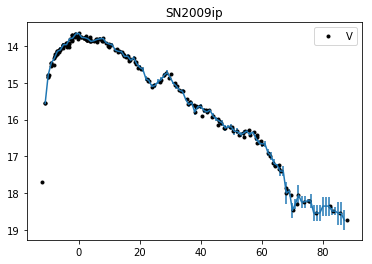

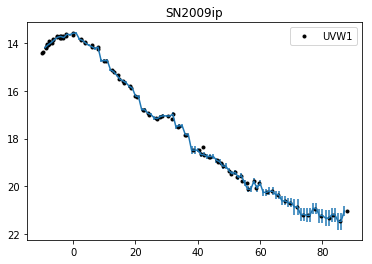

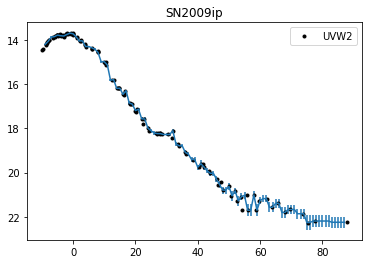

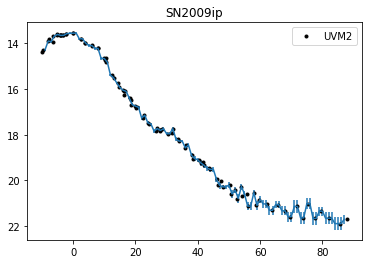

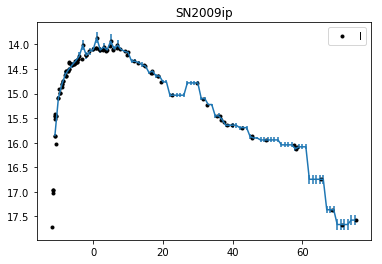

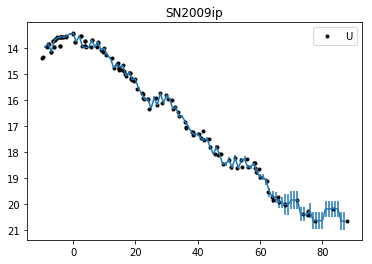

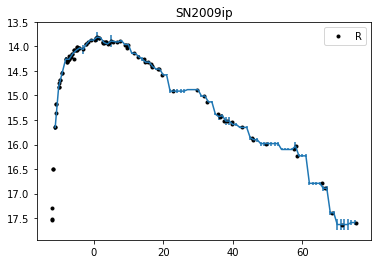

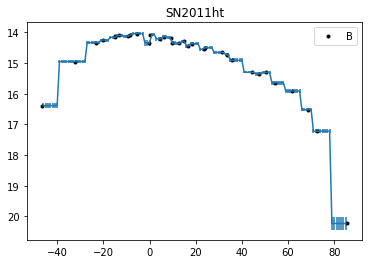

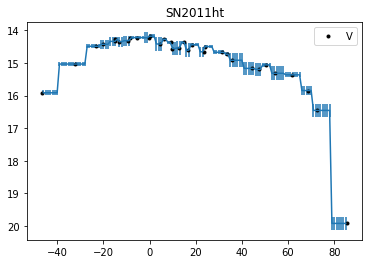

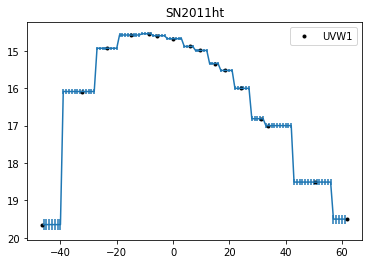

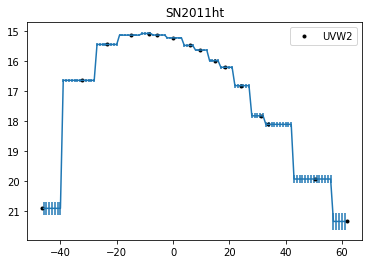

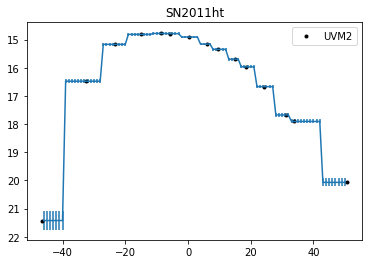

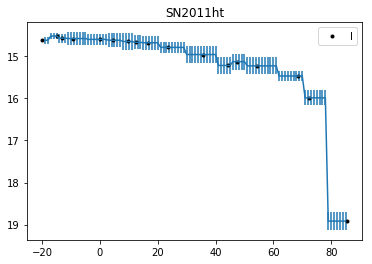

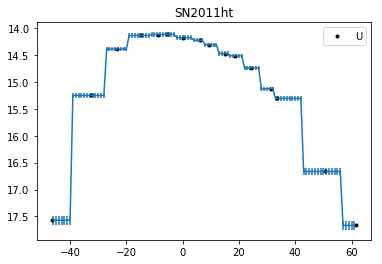

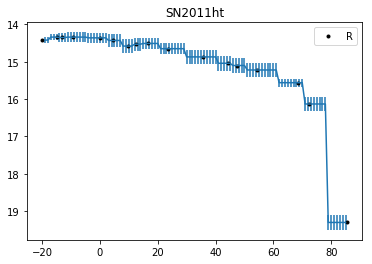

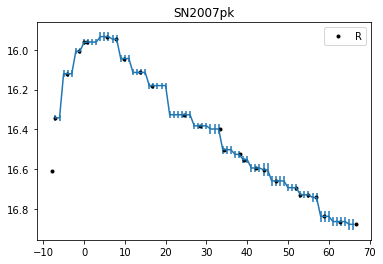

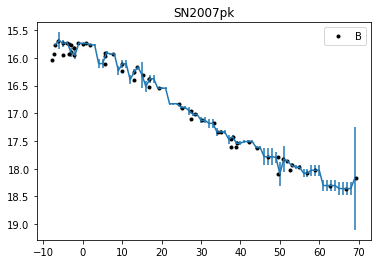

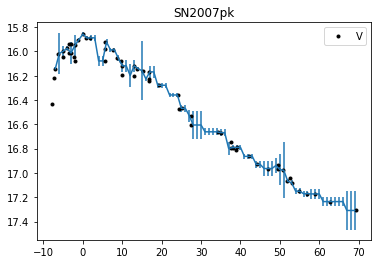

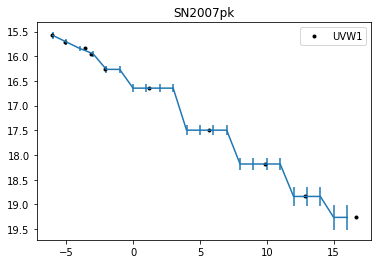

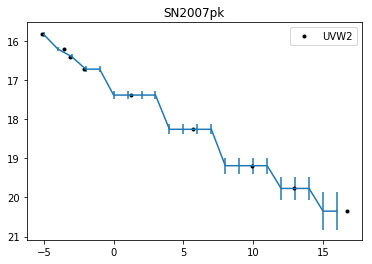

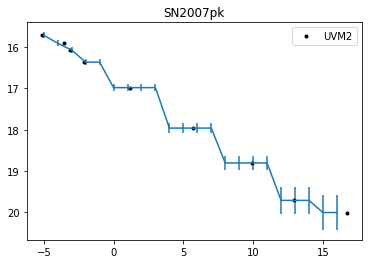

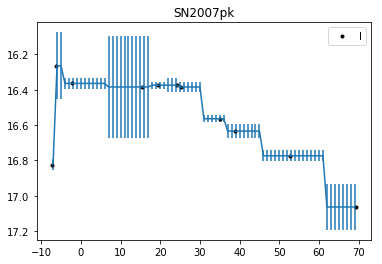

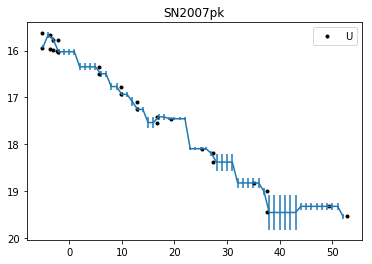

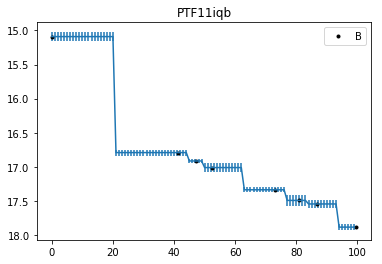

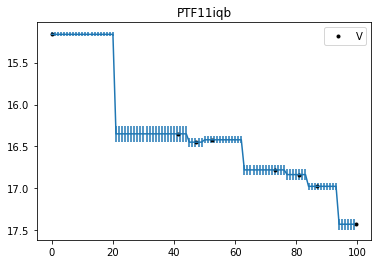

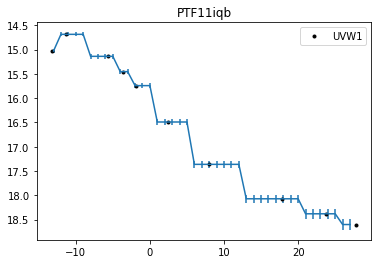

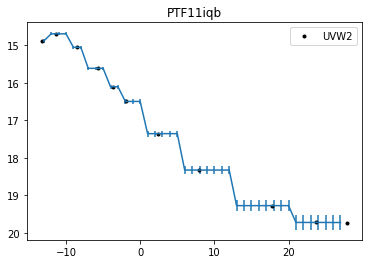

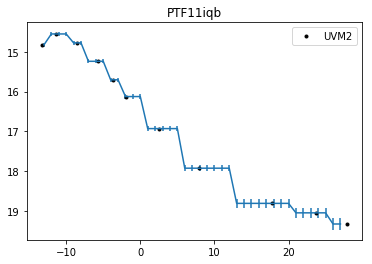

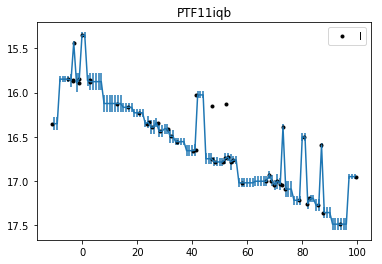

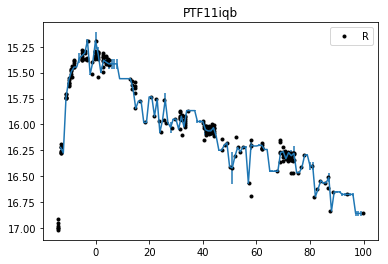

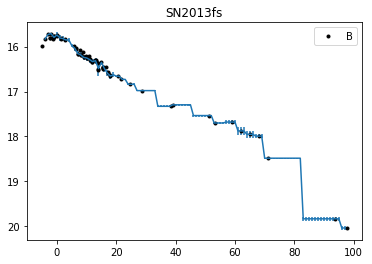

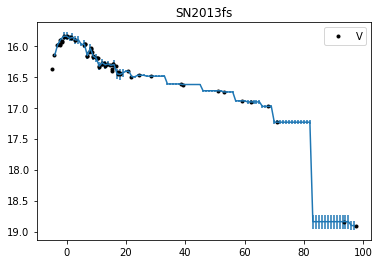

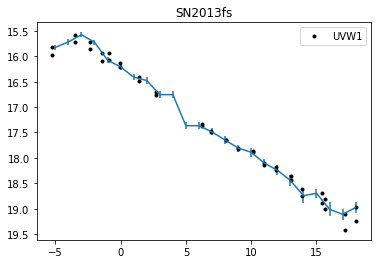

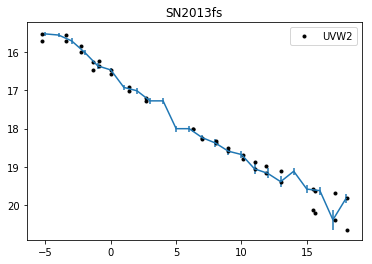

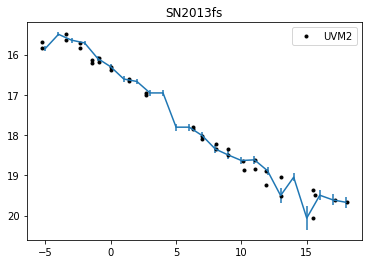

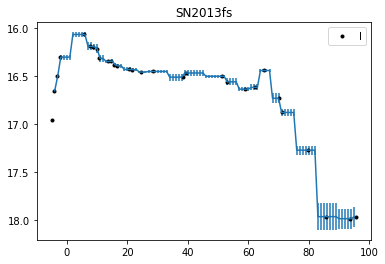

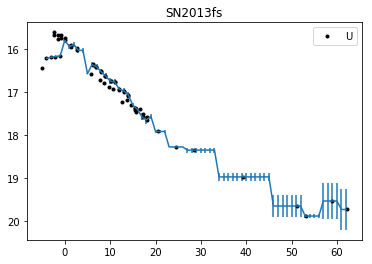

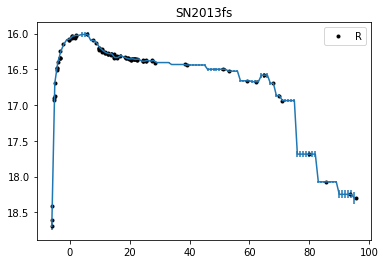

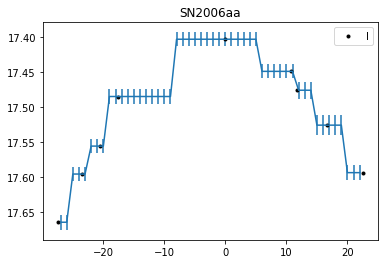

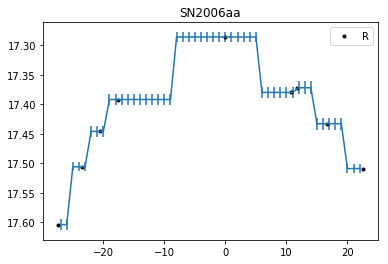

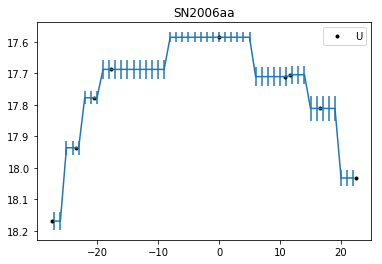

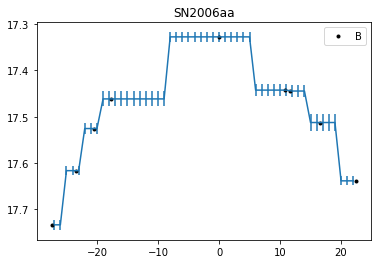

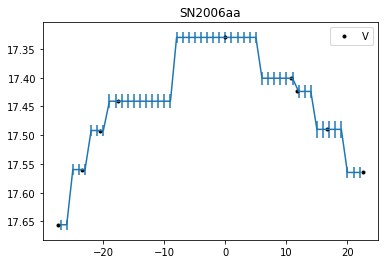

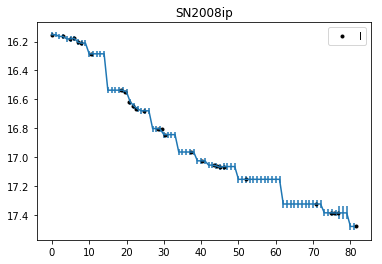

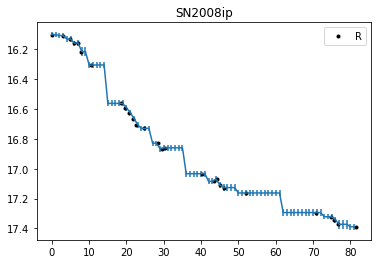

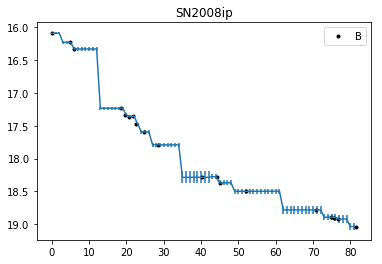

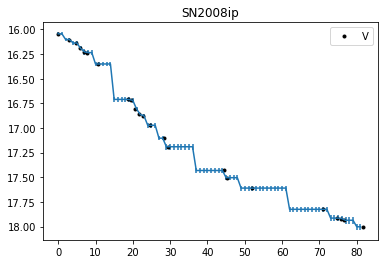

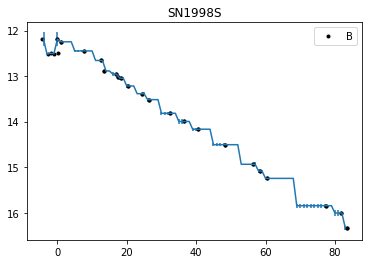

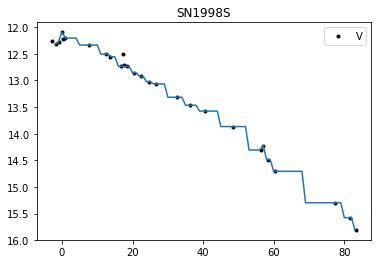

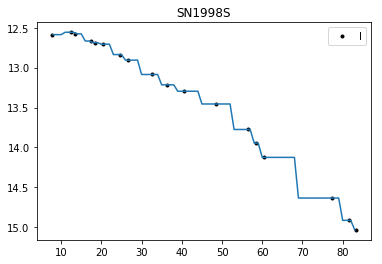

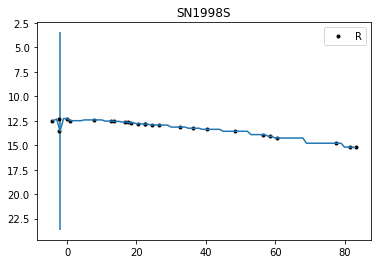

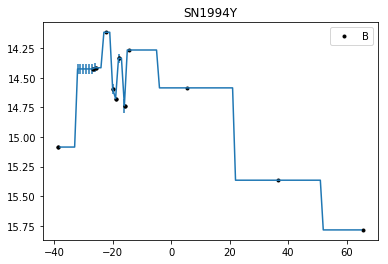

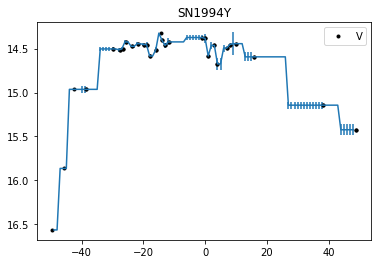

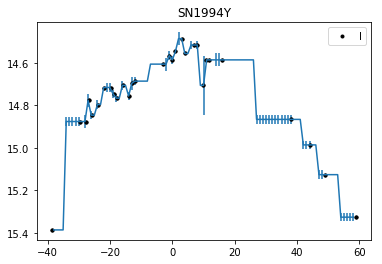

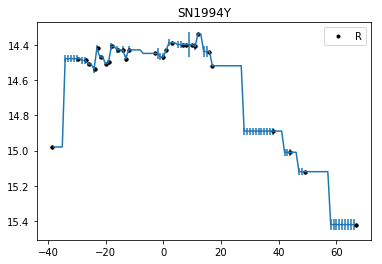

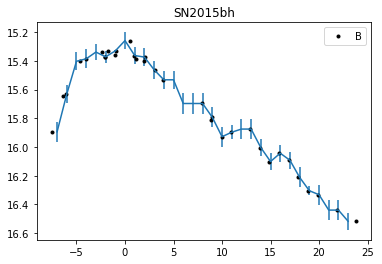

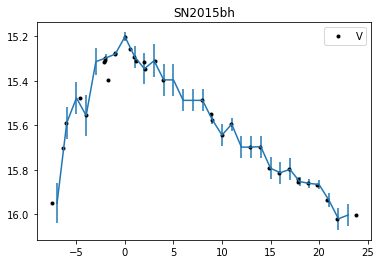

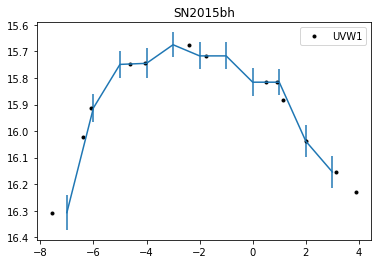

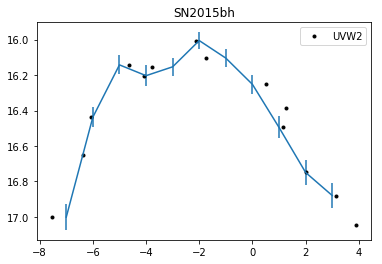

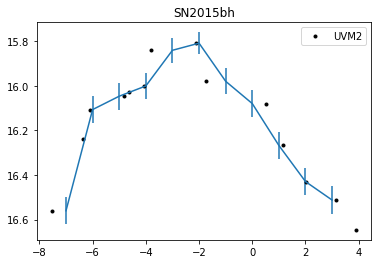

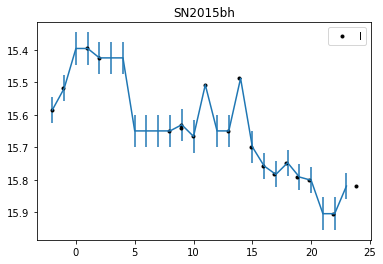

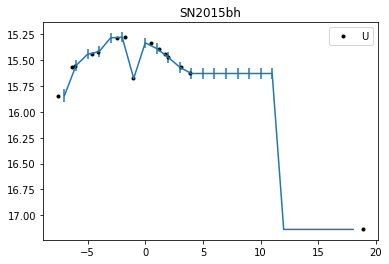

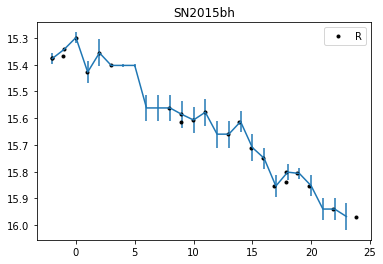

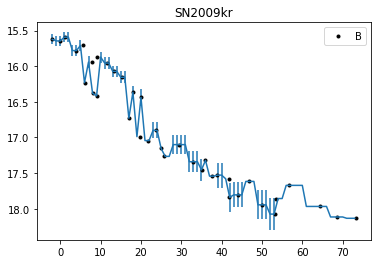

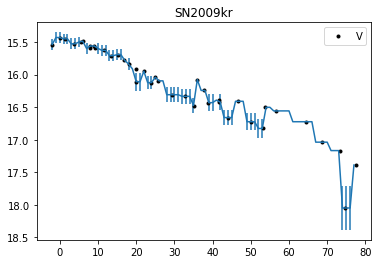

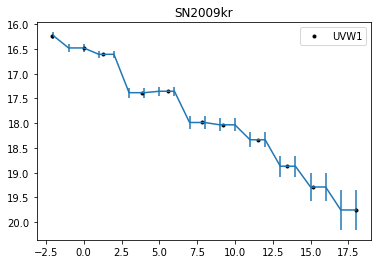

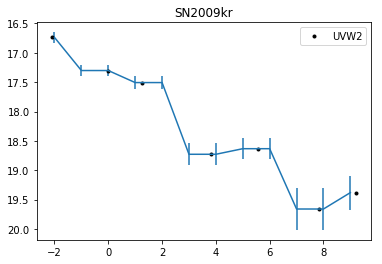

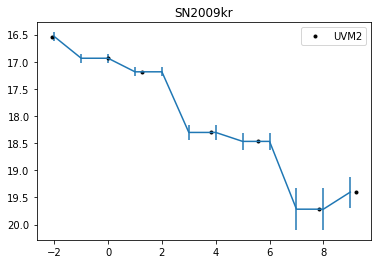

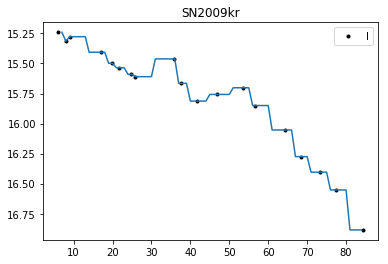

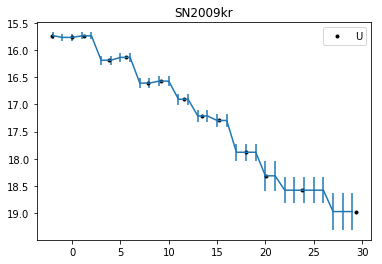

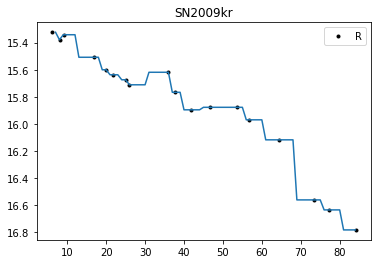

In [26]:
interpolModel = {}
for j in dat['event'].unique():
    a = dat[dat['event']==j]
    for i in a['band'].unique():
        x = a[a['band']==i]
        interpolModel[(j,i)] = {}
        interpolModel[(j,i)]['magAB'] = interp1d(x['phase'],x['magAB'],kind='nearest')
        interpolModel[(j,i)]['e_magnitude'] = interp1d(x['phase'],x['e_magnitude'],kind='nearest')
        interpolModel[(j,i)]['trange'] = (math.ceil(min(x['phase'])),math.floor(max(x['phase']))+1)

        plt.figure()
        plt.plot(x['phase'],x['magAB'],'k.',label=i)
        tgrid = np.arange(interpolModel[(j,i)]['trange'][0],interpolModel[(j,i)]['trange'][1],step=1)
        plt.errorbar(tgrid
                     ,interpolModel[(j,i)]['magAB'](tgrid)
                     ,interpolModel[(j,i)]['e_magnitude'](tgrid))
        plt.gca().invert_yaxis()
        plt.title(j)
        plt.legend()
        plt.show()

# Quad on mag

In [84]:
# key = {'SN2009ip': (-15,15)
#       ,'SN2007pk': (-10,10)
#       ,'SN2013fs': (-15,10)}

# for i in dat['band'].unique():
#     x = dat[dat['band']==i]
#     for j in x['event'].unique():
#         y = x[x['event']==j]
#         if j in key.keys():
#             z = y[y['phase']>=key[j][0]]
#             z = z[z['phase']<=key[j][1]]
#         else:
#             z = y.copy()
        
#         popt,pcov = None,None
#         try:
#             popt,pcov = curve_fit(quad,z['phase'],z['magAB'],sigma=z['e_magnitude'],p0=[1.,0.,14.])
#         except:
#             print('Exception: {}'.format(i,j))
#         plt.figure()
#         plt.errorbar(y['phase'],y['magAB'],y['e_magnitude'],marker='x',linestyle='',label='{0} {1}'.format(i,j))
#         try:
#             plt.plot(z['phase'],quad(z['phase'],*popt),label='{}'.format(popt))
#         except:
#             pass
#         plt.gca().invert_yaxis()
#         plt.legend()
#         plt.show()
        

# Color index

Exception SN2006aa ['UVW2' 'UVM2']
Exception SN2008ip ['UVW2' 'UVM2']
Exception SN1998S ['UVW2' 'UVM2']
Exception SN1994Y ['UVW2' 'UVM2']


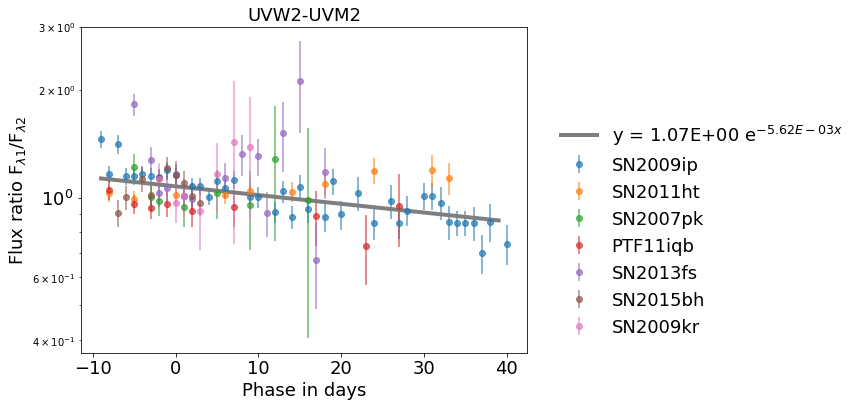

Exception SN2006aa ['UVM2' 'UVW1']
Exception SN2008ip ['UVM2' 'UVW1']
Exception SN1998S ['UVM2' 'UVW1']
Exception SN1994Y ['UVM2' 'UVW1']


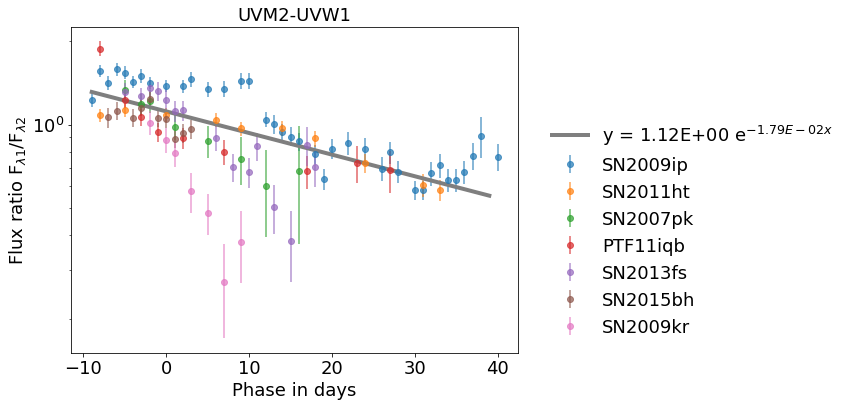

Exception PTF11iqb ['UVW1' 'U']
Exception SN2006aa ['UVW1' 'U']
Exception SN2008ip ['UVW1' 'U']
Exception SN1998S ['UVW1' 'U']
Exception SN1994Y ['UVW1' 'U']


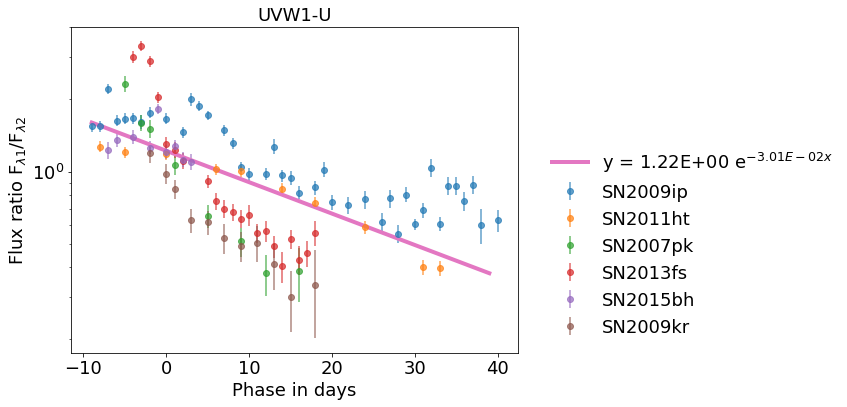

Exception PTF11iqb ['U' 'B']
Exception SN2008ip ['U' 'B']
Exception SN1998S ['U' 'B']
Exception SN1994Y ['U' 'B']
Exception SN2015bh ['U' 'B']


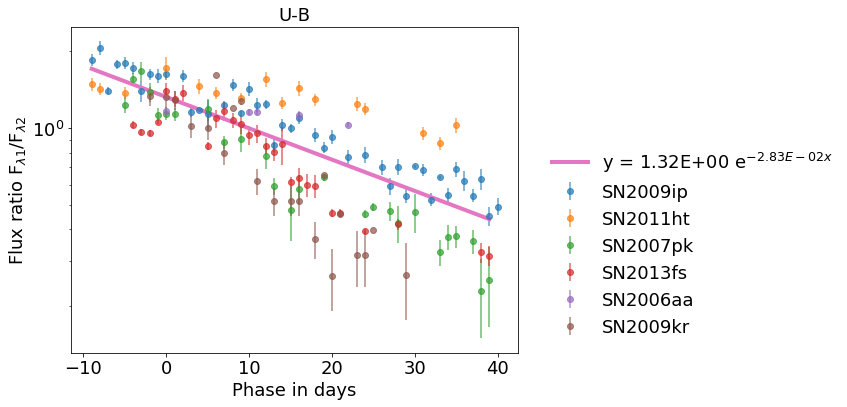

Exception SN2009kr ['B' 'V']


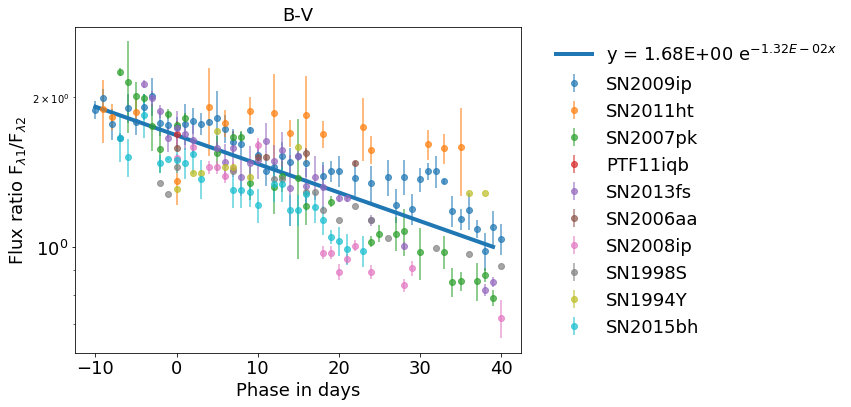

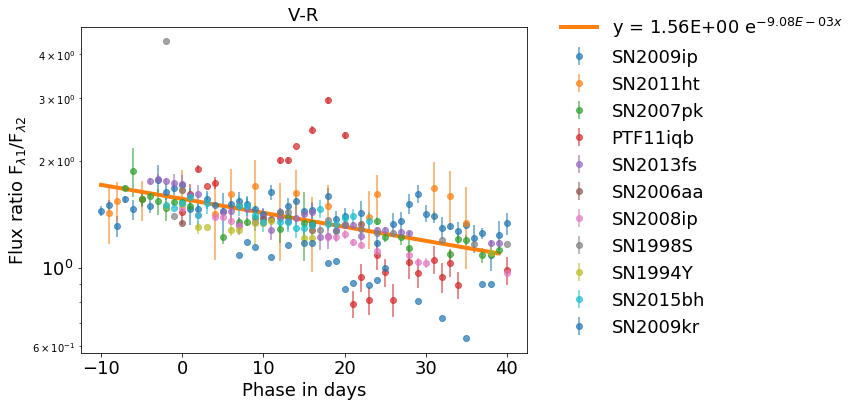

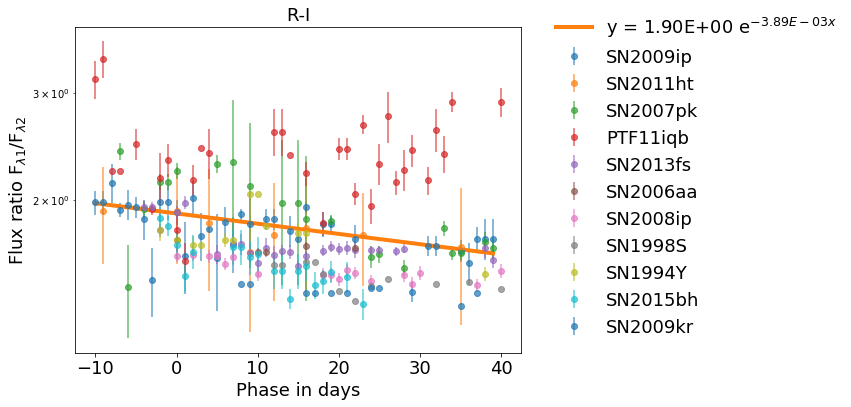

Exception SN2006aa ['UVM2' 'V']
Exception SN2008ip ['UVM2' 'V']
Exception SN1998S ['UVM2' 'V']
Exception SN1994Y ['UVM2' 'V']


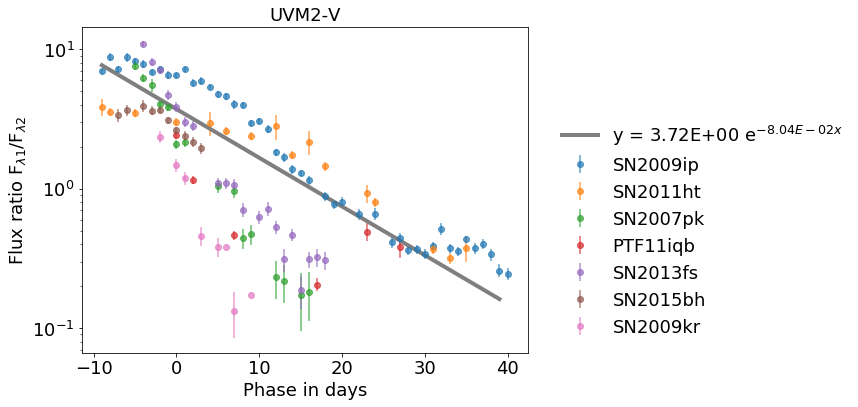

Exception SN2006aa ['UVW2' 'V']
Exception SN2008ip ['UVW2' 'V']
Exception SN1998S ['UVW2' 'V']
Exception SN1994Y ['UVW2' 'V']


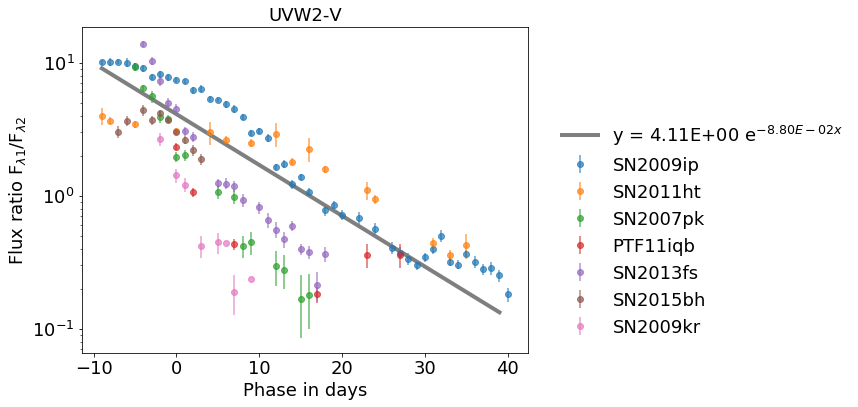

Exception SN2006aa ['UVW1' 'V']
Exception SN2008ip ['UVW1' 'V']
Exception SN1998S ['UVW1' 'V']
Exception SN1994Y ['UVW1' 'V']
Exception SN2009kr ['UVW1' 'V']


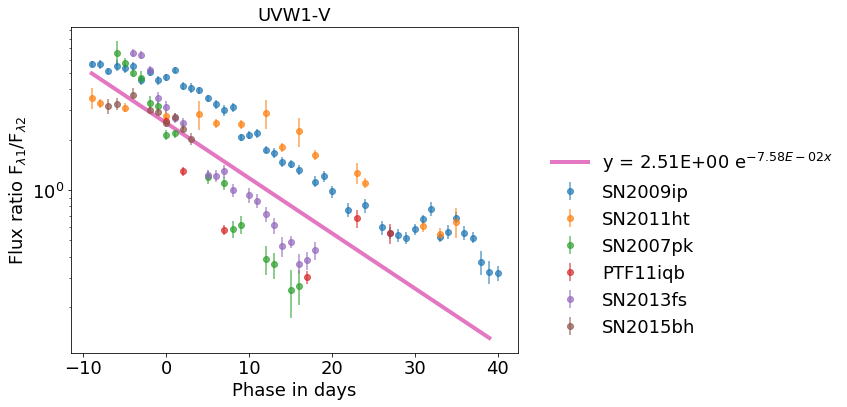

In [265]:
colorpair = np.array([('UVW2','UVM2'),('UVM2','UVW1'),('UVW1','U')
                     ,('U','B'),('B','V'),('V','R'),('R','I'),('UVM2','V'),('UVW2','V'),('UVW1','V')])
xmin = -10
xmax = 40

cccindex = {}
for i in colorpair:
    plt.figure(figsize=(8,6))
    keepx,keepy,keepey=np.array([]),np.array([]),np.array([])
    for j in dat['event'].unique():
        try:
            x = dat[dat['event']==j]
            t,tt = x[x['band']==i[0]]['phase'].astype('int64'),x[x['band']==i[1]]['phase'].astype('int64')
            tmin = max(interpolModel[(j,i[0])]['trange'][0],interpolModel[(j,i[1])]['trange'][0])
            tmax = min(interpolModel[(j,i[0])]['trange'][1],interpolModel[(j,i[1])]['trange'][1])
            tgrid = np.union1d(t,tt)
            tgrid = tgrid[tgrid>=tmin]
            tgrid = tgrid[tgrid<=tmax]
        
            f1 = mag2flux(interpolModel[(j,i[0])]['magAB'](tgrid),wavelength[i[0]])
            f2 = mag2flux(interpolModel[(j,i[1])]['magAB'](tgrid),wavelength[i[1]])
            r = f1/f2

            ef1 = mag2eflux(f1,interpolModel[(j,i[0])]['e_magnitude'](tgrid))
            ef2 = mag2eflux(f2,interpolModel[(j,i[1])]['e_magnitude'](tgrid))
            er = np.sqrt((ef1/f2)**2 + (ef2*r/f2)**2)

            index = np.intersect1d(np.argwhere(tgrid>=xmin).flatten(),np.argwhere(tgrid<=xmax).flatten())
            plt.errorbar(tgrid[index],r[index],er[index],marker='o',linestyle='',alpha=0.7,label=j)
            
            keepx = np.concatenate((keepx,tgrid[index]),axis=None)
            keepy = np.concatenate((keepy,r[index]),axis=None)
            keepey = np.concatenate((keepey,er[index]),axis=None)
        except:
            print('Exception {} {}'.format(j,i))
    
    try:
        popt,pcov = curve_fit(expo,keepx,keepy,sigma=keepey,p0=[1.,-2e-2])
    except:
        try:
            popt,pcov = curve_fit(expo,keepx,keepy,p0=[1.,-2e-2])
        except:
            continue
    
    cccindex[('expo',i[0],i[1])] = (popt,pcov)
    tgrid = np.arange(min(keepx),max(keepx),step=1)
    l1 = plt.plot(tgrid,expo(tgrid,*popt),label='y = {0:.2E} e$^{{{1:.2E}x}}$'.format(popt[0],popt[1]))
    
    plt.yscale('log')
    plt.title('{0}-{1}'.format(i[0],i[1]),fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Phase in days',fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Flux ratio F$_{\lambda1}$/F$_{\lambda2}$',fontsize=18)
    plt.setp(l1, linewidth=4)
    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
    plt.savefig(r'D:\Model_SED_IIn\plot_94_colorindex_'+i[0]+'_'+i[1]+'.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [266]:
with open('colorindex.pickle','wb') as handle:
    pickle.dump(cccindex,handle,protocol=pickle.HIGHEST_PROTOCOL)

# Temperature

In [357]:
temperature = {}

#########################################################################################

bandopt=['B','V','R','I']
for j in dat['event'].unique():
    temperature[(j,'opt')] = {}
    
    x = dat[dat['event']==j]
    x = x[x['band'].isin(bandopt)]
    
    tgrid = x['phase'].astype('int64').unique()
        
    for i in tgrid:
        w = []
        f = []
        ef = []
        for k in bandopt:
            try:
                x = mag2flux(interpolModel[(j,k)]['magAB'](i),wavelength[k])
                f.append(x)
                ef.append(mag2eflux(x,interpolModel[(j,k)]['e_magnitude'](i)))
                w.append(wavelength[k])
            except:
                continue
        
        if len(w)<3:
            continue
        else:
            try:
                popt,pcov = curve_fit(planck,w,f,sigma=ef,p0=[10000.,1e-23],maxfev=10000)
                temperature[(j,'opt')][i] = (popt,pcov)
            except:
                print('Exception, cannot find opt solution {0} {1} days'.format(j,i))
                pass
        
# #########################################################################################

bandopt=['UVW2','UVM2','UVW1']
for j in dat['event'].unique():
    temperature[(j,'UV')] = {}
    
    x = dat[dat['event']==j]
    x = x[x['band'].isin(bandopt)]
    
    trid = x['phase'].astype('int64').unique()
        
    for i in tgrid:
        w = []
        f = []
        ef = []
        for k in bandopt:
            try:
                x = mag2flux(interpolModel[(j,k)]['magAB'](i),wavelength[k])
                f.append(x)
                ef.append(mag2eflux(x,interpolModel[(j,k)]['e_magnitude'](i)))
                w.append(wavelength[k])
            except:
                continue
        
        if len(w)<3:
            continue
        else:
            try:
                popt,pcov = curve_fit(planck,w,f,sigma=ef,p0=[10000.,1e-23],maxfev=10000)
                temperature[(j,'UV')][i] = (popt,pcov)
            except:
                print('Exception, cannot find UV solution {0} {1} days'.format(j,i))
                pass


C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in expm1


Exception, cannot find opt solution PTF11iqb 69 days
Exception, cannot find opt solution PTF11iqb 71 days
Exception, cannot find opt solution PTF11iqb 3 days
Exception, cannot find opt solution PTF11iqb 14 days


C:\Users\Kornpob\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Exception, cannot find opt solution SN1998S -2 days
Exception, cannot find opt solution SN1998S -1 days
Exception, cannot find opt solution SN1998S 0 days
Exception, cannot find opt solution SN1998S 7 days
Exception, cannot find opt solution SN1998S 12 days
Exception, cannot find opt solution SN1998S 13 days
Exception, cannot find opt solution SN1998S 16 days
Exception, cannot find opt solution SN1998S 17 days
Exception, cannot find opt solution SN1998S 18 days
Exception, cannot find opt solution SN1998S 20 days
Exception, cannot find opt solution SN1998S 24 days
Exception, cannot find opt solution SN1998S 26 days
Exception, cannot find opt solution SN1998S 32 days
Exception, cannot find opt solution SN1998S 36 days
Exception, cannot find opt solution SN1998S 40 days
Exception, cannot find opt solution SN1998S 48 days
Exception, cannot find opt solution SN1998S 56 days
Exception, cannot find opt solution SN1998S 58 days
Exception, cannot find opt solution SN1998S 60 days
Exception, can

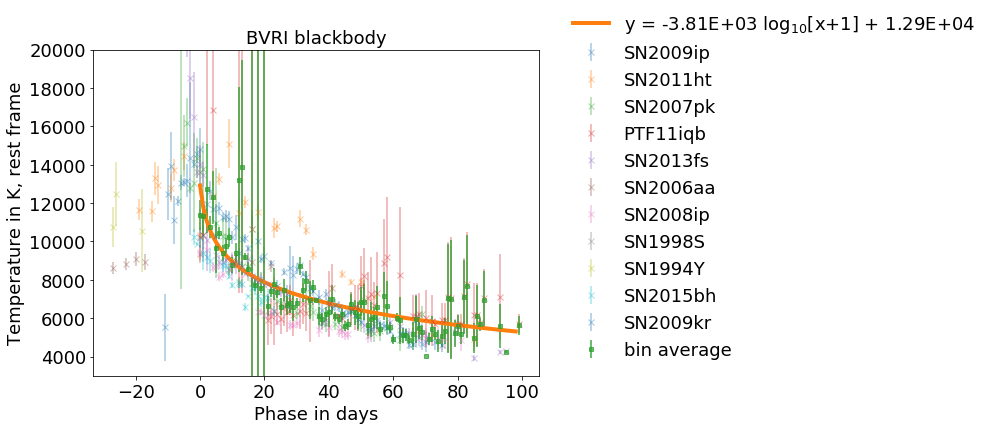

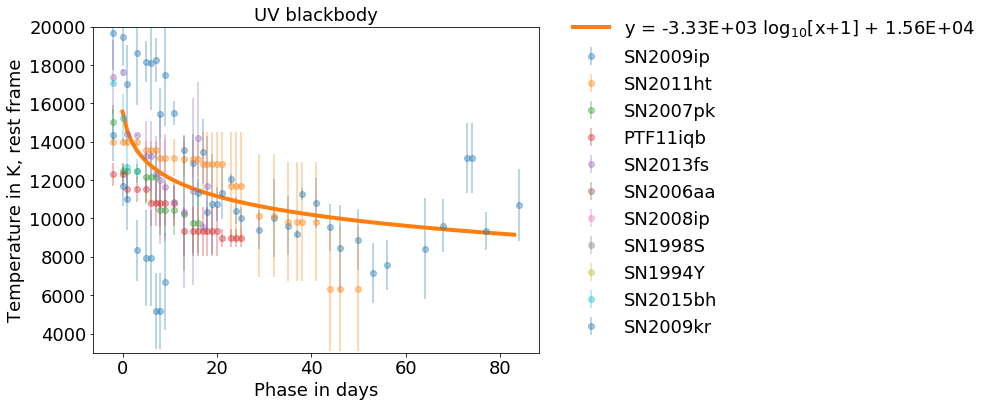

In [363]:
plt.figure(figsize=(8,6))
keepx,keepy,keepey = np.array([]),np.array([]),np.array([])
for j in dat['event'].unique():
#     if j in {'PTF11iqb'}:
#         continue
    x = temperature[(j,'opt')]
    a = []
    b = []
    eb = []
    for i in x.keys():
        a.append(i)
        b.append(x[i][0][0])
        eb.append(np.sqrt(x[i][1][0,0]))
    a = np.array(a)
    b = np.array(b)*(1.+meta[j]['redshift'])
    eb = np.array(eb)*(1.+meta[j]['redshift'])
    plt.errorbar(a,b,eb,marker='x',linestyle='',alpha=0.4,label=j)
    
    keepx = np.concatenate((keepx,a),axis=None)
    keepy = np.concatenate((keepy,b),axis=None)
    keepey = np.concatenate((keepey,eb),axis=None)
    
index = np.argwhere(keepx>=0).flatten()
# popt,pcov = curve_fit(expo,keepx[index],keepy[index],sigma=keepey[index],p0=[15000,-1],maxfev=10000)
popt,pcov = curve_fit(semilog10x,keepx[index],keepy[index],sigma=keepey[index],p0=[-1,15000],maxfev=10000)
temperature[('semilog10x','opt')] = (popt,pcov)
tgrid = np.arange(0,max(keepx),step=1)
l1 = plt.plot(tgrid,semilog10x(tgrid,*popt),label='y = {0:.2E} log$_{{10}}$[x+1] + {1:.2E}'.format(popt[0],popt[1]))

x,y,ey = temperature[('bin','opt')]
index = np.argsort(x)
plt.errorbar(x[index],y[index,0],ey[index,0],marker='s',linestyle='',markersize=4,linewidth=2,alpha=0.7,label='bin average')

plt.ylim(3000,20000)
# plt.ylim(1e-5,1e-3)
# plt.xscale('log')
# plt.yscale('log')
plt.title('BVRI blackbody',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Phase in days',fontsize=18)
plt.ylabel('Temperature in K, rest frame',fontsize=18)
plt.setp(l1, linewidth=4)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_94_tempopt.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#####################################################################################################

# plt.figure()
# for j in dat['event'].unique():
#     x = temperature[(j,'opt')]
#     a = []
#     b = []
#     eb = []
#     for i in x.keys():
#         a.append(i)
#         b.append(x[i][0][1])
#         eb.append(np.sqrt(x[i][1][1,1]))
#     a = np.array(a)
#     b = np.array(b)
#     eb = np.array(eb)
#     A = 4. * 3.14159 * (meta[j]['lumdistMpc'] * 3.086e24)**2
#     plt.errorbar(a,b*A,marker='o',linestyle='',alpha=0.7,label=j)
    
# plt.title('BVRI blackbody scale')
# lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
# plt.show()

# #####################################################################################################

# plt.figure()
# for j in dat['event'].unique():
#     x = temperature[(j,'UV')]
#     a = []
#     b = []
#     eb = []
#     for i in x.keys():
#         a.append(i)
#         b.append(x[i][0][0])
#         eb.append(np.sqrt(x[i][1][0,0]))
#     a = np.array(a)
#     b = np.array(b)*(1.+meta[j]['redshift'])
#     eb = np.array(eb)*(1.+meta[j]['redshift'])
#     plt.errorbar(a,b,eb,marker='o',linestyle='',alpha=0.4,label=j)
    
# # plt.ylim(3000,20000)
# plt.title('UV blackbody')
# lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
# plt.show()

plt.figure(figsize=(8,6))
keepx,keepy,keepey = np.array([]),np.array([]),np.array([])
for j in dat['event'].unique():
    x = temperature[(j,'UV')]
    a = []
    b = []
    eb = []
    for i in x.keys():
        a.append(i)
        b.append(x[i][0][0])
        eb.append(np.sqrt(x[i][1][0,0]))
    a = np.array(a)
    b = np.array(b)*(1.+meta[j]['redshift'])
    eb = np.array(eb)*(1.+meta[j]['redshift'])
    plt.errorbar(a,b,eb,marker='o',linestyle='',alpha=0.4,label=j)
    
    keepx = np.concatenate((keepx,a),axis=None)
    keepy = np.concatenate((keepy,b),axis=None)
    keepey = np.concatenate((keepey,eb),axis=None)
    
index = np.argwhere(keepx>=0).flatten()
# popt,pcov = curve_fit(expo,keepx[index],keepy[index],sigma=keepey[index],p0=[15000,-1],maxfev=10000)
popt,pcov = curve_fit(semilog10x,keepx[index],keepy[index],sigma=keepey[index],p0=[-1,15000],maxfev=10000)
temperature[('semilog10x','UV')] = (popt,pcov)
tgrid = np.arange(0,max(keepx),step=1)
l1 = plt.plot(tgrid,semilog10x(tgrid,*popt),label='y = {0:.2E} log$_{{10}}$[x+1] + {1:.2E}'.format(popt[0],popt[1]))
    

plt.ylim(3000,20000)
# plt.ylim(1e-5,1e-3)
# plt.xscale('log')
# plt.yscale('log')
plt.title('UV blackbody',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Phase in days',fontsize=18)
plt.ylabel('Temperature in K, rest frame',fontsize=18)
plt.setp(l1, linewidth=4)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_94_tempuv.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# #####################################################################################################

# plt.figure()
# for j in dat['event'].unique():
#     x = temperature[(j,'UV')]
#     a = []
#     b = []
#     eb = []
#     for i in x.keys():
#         a.append(i)
#         b.append(x[i][0][1])
#         eb.append(np.sqrt(x[i][1][1,1]))
#     a = np.array(a)
#     b = np.array(b)
#     eb = np.array(eb)
#     A = 4. * 3.14159 * (meta[j]['lumdistMpc'] * 3.086e24)**2
#     plt.errorbar(a,b*A,marker='o',linestyle='',alpha=0.4,label=j)
    
# plt.ylim(0,1e31)
# plt.title('UV blackbody scale')
# lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
# plt.show()

6.42035177679e+17 7.70593503954e+17 -0.200235642445
chisq bin ave 6.42035177679e+17


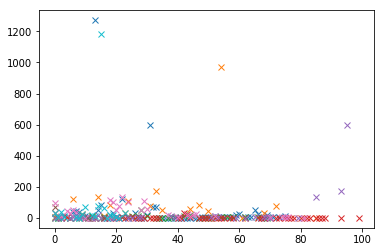

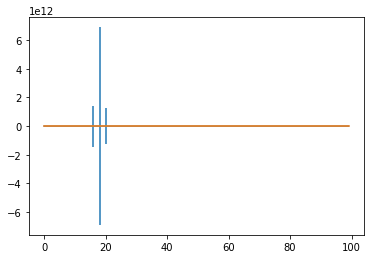

In [373]:
# Score R-sq
diff = {}
keepx,keepy,keepey = np.array([]),np.array([]),np.array([])
for i in dat['event'].unique():
#     if i in {'PTF11iqb'}:
#         continue
    tgrid = np.array(list(temperature[(i,'opt')].keys()))
    index = np.argwhere(tgrid>=0).flatten()
    tgrid = tgrid[index]
    
    popt = temperature[('semilog10x','opt')][0]
    prey = semilog10x(tgrid,*popt)
    
    obs,eobs = [],[]
    for j in tgrid:
        obs.append(temperature[(i,'opt')][j][0][0])
        eobs.append(temperature[(i,'opt')][j][1][0,0])
    obs,eobs = np.array(obs),np.sqrt(np.array(eobs))
    
    keepx = np.concatenate((keepx,tgrid),axis=None).flatten()
    keepy = np.concatenate((keepy,obs),axis=None).flatten()
    keepey = np.concatenate((keepey,eobs),axis=None).flatten()
    
    plt.plot(tgrid,(obs-prey)**2/eobs**2,marker='x',linestyle='')
#     plt.xlim(0,40)
#     plt.ylim(0,100)

########################################################

aggx,aggy,aggey = [],[],[]
for i in pd.Series(keepx).unique():
    aggx.append(i)
    index = np.argwhere(keepx==i).flatten()
    aggy.append((np.mean(keepy[index]),np.std(keepy[index])))
    aggey.append((np.mean(keepey[index]),np.std(keepey[index])))
aggx = np.array(aggx)
aggy = np.array(aggy)
aggey = np.array(aggey)
plt.figure()
index = np.argsort(aggx)
plt.errorbar(aggx[index],aggy[index,0],aggey[index,0])
plt.errorbar(aggx[index],semilog10x(aggx[index],*popt))
# plt.ylim(3000,20000)

temperature[('bin','opt')] = (aggx,aggy,aggey)

####################################################################

sstot = 0
ssres = 0
for i in aggx:
#     if i >= 20:
#         continue
    index = np.argwhere(keepx==i).flatten()
    ybar = aggy[np.argwhere(aggx==i).flatten(),0]
    sstot += np.sum(keepy[index]**2 - 2.*keepy[index]*ybar + ybar**2)
    ssres += np.sum(keepy[index]**2 - 2.*keepy[index]*semilog10x(i,*popt) + semilog10x(i,*popt)**2)
print(sstot,ssres, 1. - ssres/sstot)
print('chisq bin ave',sstot)

In [364]:
with open('temperature.pickle','wb') as handle:
    pickle.dump(temperature,handle,protocol=pickle.HIGHEST_PROTOCOL)

# Excess

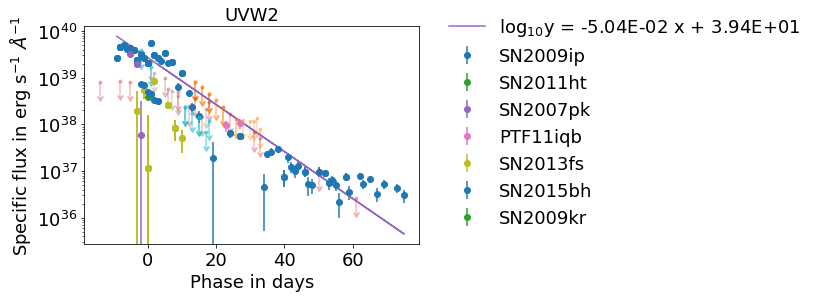

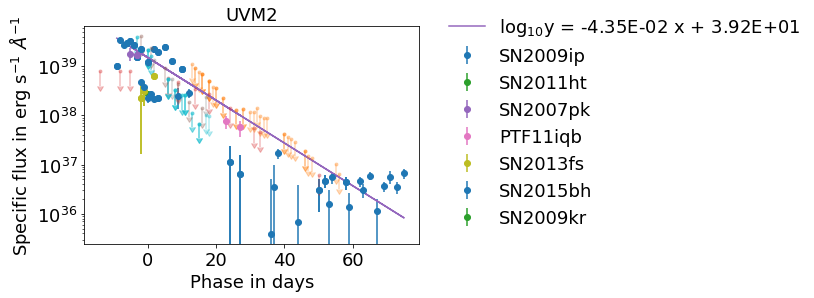

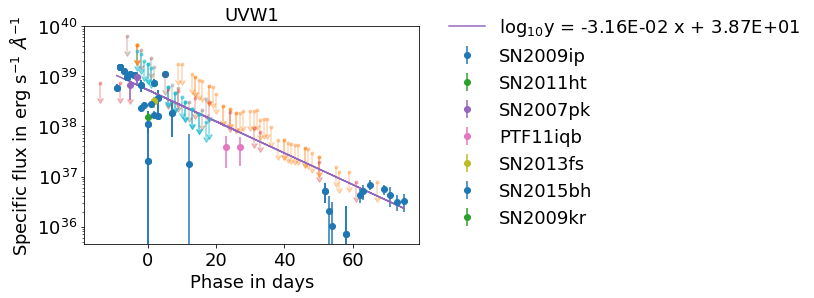

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in expm1


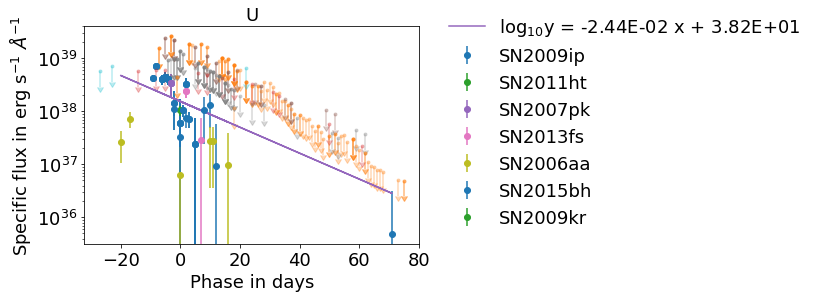

In [440]:
band = ['UVW2','UVM2','UVW1','U']
band = np.array(band)

excess = {}
for j in band:
#     plt.figure()
    keepx = []
    keepy = []
    keepey = []
    for k in dat['event'].unique():
        x = dat[dat['event']==k]
        x = x[x['band']==j]
        
        tgrid = x['phase'].astype('int64')
        
        xx,ff = [],[]
        for i in tgrid:
            w,y,ey = [],[],[]
            for l in ['B','V','R','I']:
                try:
                    a = mag2flux(interpolModel[(k,l)]['magAB'](i),wavelength[l])
                    y.append(a)
                    ey.append(mag2eflux(a,interpolModel[(k,l)]['e_magnitude'](i)))
                    w.append(wavelength[l])
                except:
                    continue

            if len(w)<3:
                continue
            else:
                try:
                    popt,pcov = curve_fit(planck,w,y,sigma=ey,p0=[10000.,1e-23],maxfev=10000)
                except:
#                     print('Exception, cannot find opt solution {0} {1} {2} days'.format(k,j,i))
                    continue
               
            xx.append(i)
            ff.append(planck(wavelength[j],*popt))
        xx,ff = np.array(xx),np.array(ff)
         
        try:
            f = mag2flux(interpolModel[(k,j)]['magAB'](xx),wavelength[j])
            ef = mag2eflux(f,interpolModel[(k,j)]['e_magnitude'](xx))
        except:
#             print('Exception, cannot interpolate {0} {1}'.format(k,j))
            continue
            
        fff = f - ff
        
        upper = np.array([0]*len(fff))
        index = np.argwhere(fff<0.).flatten()
        fff[index] = f[index]
        upper[index] = 1

        for i in [0,1]:
            marker=['o','.']
            label=[k,'']
            alpha=[1,0.3]
            color=['purple','blue','green','orange']
            index = np.argwhere(upper==i).flatten()
            A = 4. * 3.14159 * (meta[k]['lumdistMpc'] * 3.086e24)**2
            
            if i == 0:
                ee = ef[index]*A
            else:
                ee = fff[index]*A*0.5*i
            plt.errorbar(xx[index],fff[index]*A,ee,uplims=i
                         ,alpha=alpha[i],marker=marker[i],linestyle='',label=label[i])
            
            if i==0:
                try:
                    keepx.append(xx[index])
                    keepy.append(fff[index]*A)
                    keepey.append(ef[index]*A)
                except:
                    keepx = np.concatenate((keepx,xx[index]),axis=None)
                    keepy = np.concatenate((keepy,fff[index]*A),axis=None)
                    keepey = np.concatenate((keepey,ef[index]*A),axis=None)
         
        keepx,keepy,keepey = np.array(keepx).flatten(),np.array(keepy).flatten(),np.array(keepey).flatten()
    
    index = np.intersect1d(np.argwhere(keepx<=60).flatten(),np.argwhere(keepx>=0).flatten())
#     index = np.argwhere(keepx).flatten()
    popt,pcov = curve_fit(linear,keepx[index],np.log10(keepy[index]),sigma=keepey[index]/(keepy[index] * np.log(10.)),p0=[-1,38],maxfev=10000)
    excess[(j,'linear')] = (popt,pcov)
    plt.plot(keepx,10**(linear(keepx,*popt)),label='log$_{{10}}$y = {0:.2E} x + {1:.2E}'.format(popt[0],popt[1]))
    
    plt.yscale('log')
    plt.title(j,fontsize=18)
    plt.ylabel('Specific flux in erg s$^{-1}$ $\AA^{-1}$',fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Phase in days',fontsize=18)
    plt.xticks(fontsize=18)
    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
    plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_excess_evolution'+j+'.pdf', format='pdf', figsize=(16,12), dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [256]:
with open('excess.pickle','wb') as handle:
    pickle.dump(excess,handle,protocol=pickle.HIGHEST_PROTOCOL)

# Timescale factor

SN2009ip 13.53550736167355
SN2011ht 14.035369852540532
SN2007pk 15.685970051144906
PTF11iqb 15.089802844237242
SN2013fs 15.711869727000309
SN2006aa 17.327637383592798
SN2008ip 16.092633765526134
SN1994Y 14.115494384589669
SN2015bh 15.259130021919246
SN2009kr 15.5930294466942


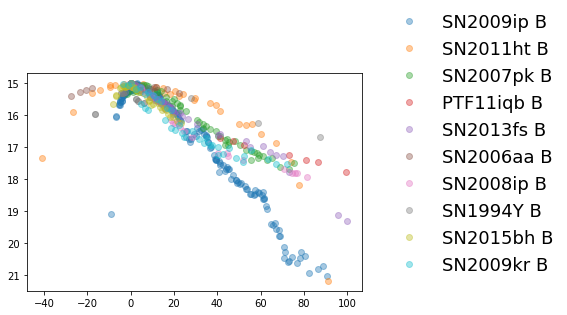

SN2009ip 13.65042611226456
SN2011ht 14.175686692002365
SN2007pk 15.857540753468298
PTF11iqb 15.16221948541113
SN2013fs 15.844747992633998
SN2006aa 17.32980072089383
SN2008ip 16.044057014445734
SN1998S 12.096217036162045
SN1994Y 14.323476391275305
SN2015bh 15.201374608629271
SN2009kr 15.429704449058237


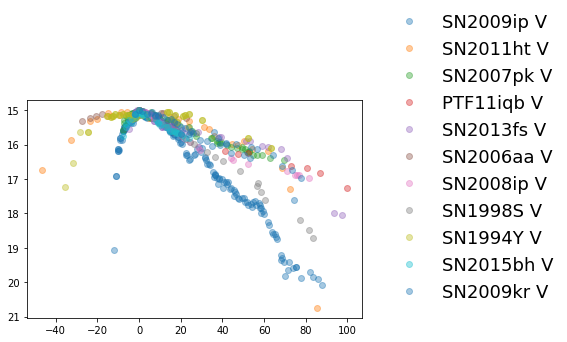

SN2009ip 13.580035503319074
SN2011ht 14.54704925958961
SN2007pk 15.578922964885006
PTF11iqb 14.685827196959893
SN2013fs 15.576065504129938
SN2015bh 15.674966984950718
SN2009kr 16.234142013276305


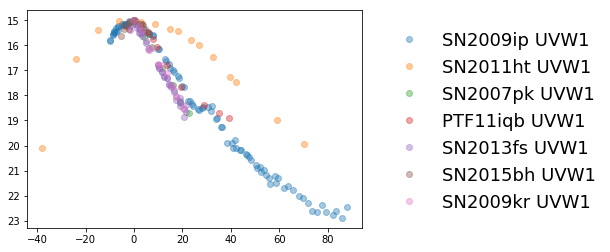

SN2011ht 15.078318664804085
SN2007pk 15.83685404976921
PTF11iqb 14.698864789812143
SN2013fs 15.528860493794971
SN2015bh 16.005223164186805
SN2009kr 16.737313266194334


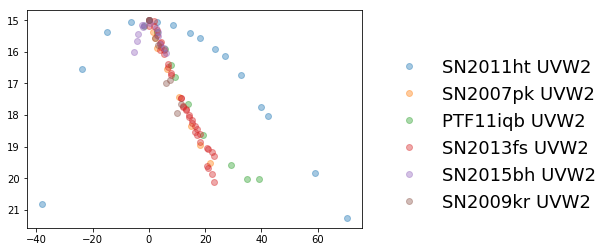

SN2009ip 13.548203004356818
SN2011ht 14.779061346085829
SN2007pk 15.719993286317546
PTF11iqb 14.551442262491692
SN2013fs 15.495262672022035
SN2015bh 15.808139979850377
SN2009kr 16.534812017427278


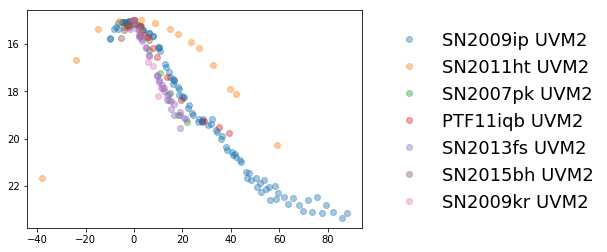

SN2009ip 13.86333677564609
SN2011ht 14.51692313200477
SN2007pk 16.26391640439139
PTF11iqb 15.351787411653588
SN2013fs 16.07023900874871
SN2006aa 17.402729520385257
SN2008ip 16.15290319419024
SN1998S 12.555694450194332
SN2015bh 15.395392744739167
SN2009kr 15.240247102584362


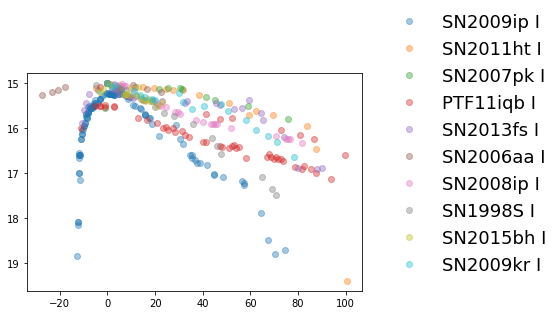

SN2009ip 13.441227507017858
SN2011ht 14.11383769452468
SN2007pk 15.622782949961787
SN2013fs 15.616010939032986
SN2006aa 17.585563057001483
SN2015bh 15.278335549983622
SN2009kr 15.737910028071433


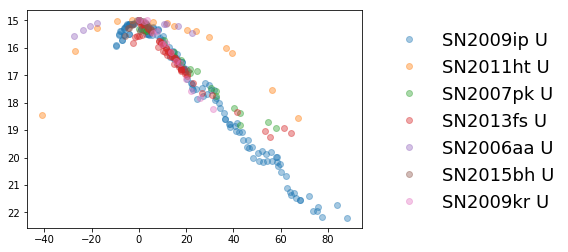

SN2009ip 13.811318221937066
SN2007pk 15.933621423107036
PTF11iqb 15.190506150945886
SN2013fs 16.011752259810347
SN2006aa 17.286013117554365
SN2008ip 16.103492217728924
SN1998S 12.280231088097368
SN2015bh 15.2986948956173
SN2009kr 15.323072887748257


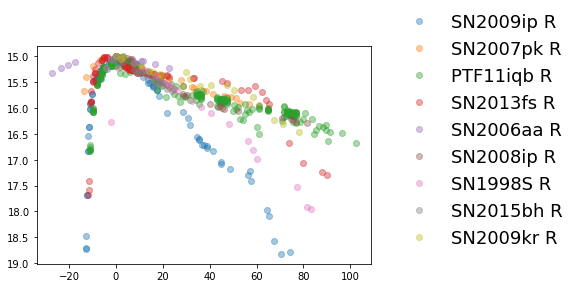

In [176]:
stdy = 15.

for j in dat['band'].unique():
    plt.figure()
    for i in dat['event'].unique():
        x = dat[dat['event']==i]
        y = x[x['band']==j]
        try:
            stdx = y[y['magAB']==min(y['magAB'])]['phase'].values
            plt.plot(y['phase'] - stdx,y['magAB'] + stdy - min(y['magAB']),marker='o',linestyle=''
                     ,alpha=0.4,label='{0} {1}'.format(i,j))
        except:
            continue
        print(i,min(y['magAB']))
#     plt.xlim(-10,40)
#     plt.ylim(15,16)
    plt.gca().invert_yaxis()
    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
    plt.show()

# Luminosity

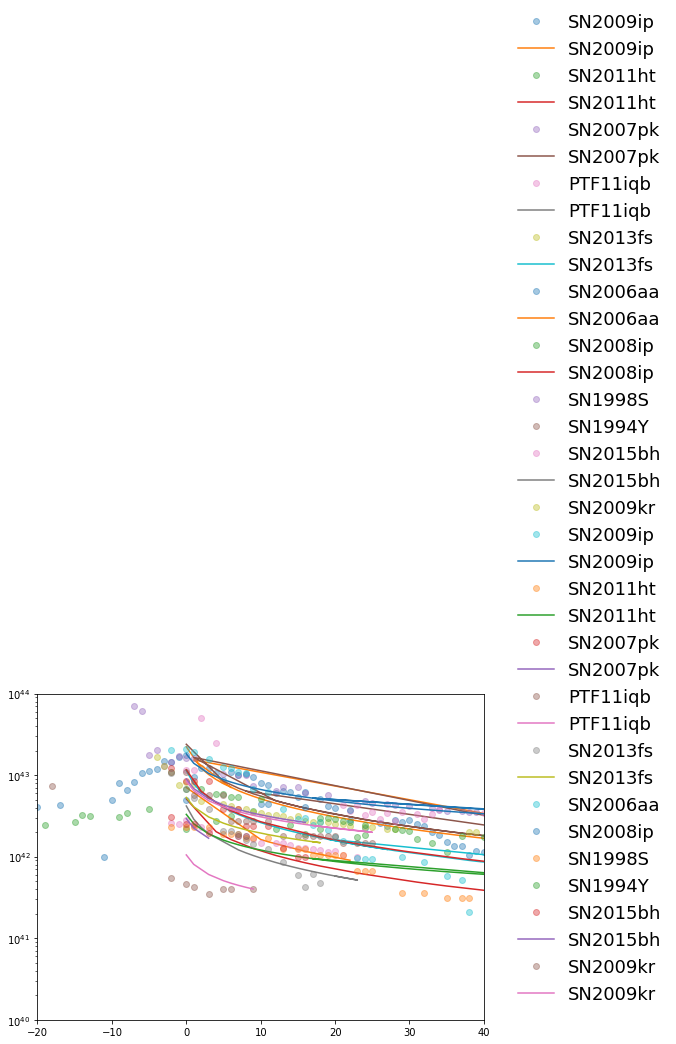

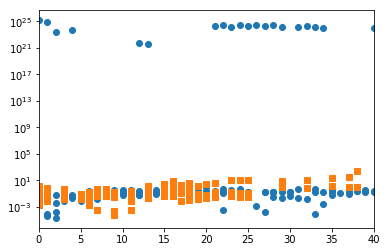

In [250]:
plt.figure(figsize=(8,6))

############################################################
keepx,keepy = np.array([]),np.array([])
for i in temperature.keys():
    if not i[1] in {'opt'}:
        continue
    try:
        tgrid = np.array(list(temperature[i].keys()))
    except:
        continue
    lum = []
    for j in tgrid:
        popt = temperature[i][j][0]
        A = 4. * 3.14159 * (meta[i[0]]['lumdistMpc'] * 3.086e24)**2
        sigma = 5.670373e-5
        l = A * sigma * popt[0]**4 * popt[1] # erg/s
        lum.append(l)
    lum = np.array(lum)
    
    index = np.argsort(tgrid)
    plt.plot(tgrid[index],lum[index],marker='o',linestyle='',alpha=0.4,label=i[0])

    ###########################################
    try:
        popt = temperature[('semilog10x','opt')][0]
        index = np.argwhere(tgrid>=0).flatten()        
        l = semilog10x(tgrid[index],*popt)**4
        
        pp,pc = curve_fit(scale,l,lum[index],p0=[max(lum[index])/max(l)])
        
        lumfit = l*pp[0]
        plt.plot(tgrid[index],lumfit,label=i[0])
        
        residualsq = ((lumfit - lum[index])/lum[index])**2
        keepx = np.concatenate((keepx,tgrid[index]),axis=None)
        keepy = np.concatenate((keepy,residualsq),axis=None)
    except:
        pass
    
    ##########################################
        
##############################################################

keepxuv,keepyuv = np.array([]),np.array([])
for i in temperature.keys():
    if not i[1] in {'UV'}:
        continue
    try:
        tgrid = np.array(list(temperature[i].keys()))
    except:
        continue
    lum = []
    for j in tgrid:
        popt = temperature[i][j][0]
        A = 4. * 3.14159 * (meta[i[0]]['lumdistMpc'] * 3.086e24)**2
        sigma = 5.670373e-5
        l = A * sigma * popt[0]**4 * popt[1] # erg/s
        lum.append(l)
    lum = np.array(lum)
    
    index = np.argsort(tgrid)
    plt.plot(tgrid[index],lum[index],marker='o',linestyle='',alpha=0.4,label=i[0])

    ###########################################
    try:
        popt = temperature[('semilog10x','UV')][0]
        index = np.argwhere(tgrid>=0).flatten()        
        l = semilog10x(tgrid[index],*popt)**4
        
        pp,pc = curve_fit(scale,l,lum[index],p0=[max(lum[index])/max(l)])
        
        lumfit = l*pp[0]
        plt.plot(tgrid[index],lumfit,label=i[0])
        
        residualsq = ((lumfit - lum[index])/lum[index])**2
        keepxuv = np.concatenate((keepxuv,tgrid[index]),axis=None)
        keepyuv = np.concatenate((keepyuv,residualsq),axis=None)
    except:
        pass
    
    ##########################################
    
############################################################


    
plt.xlim(-20,40)
plt.ylim(1e40,1e44)
plt.yscale('log')
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.show()

plt.figure()
index = np.argsort(keepx)
plt.plot(keepx[index],keepy[index],marker='o',linestyle='')

index = np.argsort(keepxuv)
plt.plot(keepxuv[index],keepyuv[index],marker='s',linestyle='')
plt.xlim(0,40)
plt.yscale('log')
plt.show()
